### **imports**

In [ ]:
# https://vigneshwarilango.medium.com/predicting-continuous-target-variables-with-images-demand-forecasting-e05145e822fe
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from keras.preprocessing.image import ImageDataGenerator

### **hyperparameters**

In [ ]:
loss_used = 'mean_squared_error'
metrics = ['mean_squared_error']
optimizer = 'adam'
batch_size = 64
epochs = 5

### **saving locations**

In [ ]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(100, 100, 3), include_top=False, weights='imagenet')

for i in pre_trained_model.layers:
  i.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('block5_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 512)


In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='linear')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=loss_used, metrics=metrics)
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

### **load data**

In [ ]:
import pandas as pd

df = pd.read_csv('processed.csv')
df.head()

,id,title,poster_path,popularity,vote_count,vote_average
0,550988,Free Guy,/xmbU4JTUm8rsdtn7Y3Fcm30GpeT.jpg,10620.879,1586,8.0
1,568620,Snake Eyes: G.I. Joe Origins,/uIXF0sQGXOxQhbaEaKOi2VYlIL0.jpg,5798.715,512,7.0
2,637534,The Stronghold,/nLanxl7Xhfbd5s8FxPy8jWZw4rv.jpg,3775.194,334,7.8
3,589754,The Last Warrior: Root of Evil,/5VJSIAhSn4qUsg5nOj4MhQhF5wQ.jpg,2768.295,31,7.6
4,703771,Deathstroke: Knights & Dragons - The Movie,/vFIHbiy55smzi50RmF8LQjmpGcx.jpg,2446.227,234,7.0


In [ ]:
# https://stats.stackexchange.com/questions/6418/rating-system-taking-account-of-number-of-votes
def weighted_rating(R, v):
  C = df['vote_average'].mean()
  m = 3000
  return (v / (v + m)) * R + (m / (v + m)) * C

In [ ]:
from sklearn.model_selection import train_test_split

df['weighted_score'] = weighted_rating(df['vote_count'], df['vote_average'])
df['poster_path'] = 'drive/MyDrive/images' + df['poster_path']
needed = df[['poster_path', 'weighted_score']]
train_df, test_df = train_test_split(needed, test_size=0.2)

### **generators**

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.20,
    fill_mode='nearest')

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='poster_path',
    y_col='weighted_score',
    subset='training', 
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(100, 100))

valid_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='poster_path',
    y_col='weighted_score',
    subset='validation', 
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(100, 100))

test_datagen = ImageDataGenerator(rescale=1./255.)

test_den = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='poster_path',
    y_col=None,
    batch_size=batch_size,
    seed=42,
    class_mode=None,
    target_size=(100, 100))

Found 6372 validated image filenames.
Found 1593 validated image filenames.
Found 1992 validated image filenames.


In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('acc') is not None and logs.get('acc') > 0.999:
      print('reached 99.9% accuracy so stopped training')
      self.model.stop_training = True

In [ ]:
callbacks = MyCallback()
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, verbose=1, callbacks=[callbacks])

Epoch 1/5
200/200 [==============================] - 821s 4s/step - loss: 40.2905 - mean_squared_error: 40.2905 - val_loss: 35.6032 - val_mean_squared_error: 35.6032
Epoch 2/5
200/200 [==============================] - 802s 4s/step - loss: 38.9082 - mean_squared_error: 38.9082 - val_loss: 36.1031 - val_mean_squared_error: 36.1031
Epoch 3/5
200/200 [==============================] - 798s 4s/step - loss: 38.6792 - mean_squared_error: 38.6792 - val_loss: 39.0388 - val_mean_squared_error: 39.0388
Epoch 4/5
200/200 [==============================] - 801s 4s/step - loss: 38.4988 - mean_squared_error: 38.4988 - val_loss: 34.5745 - val_mean_squared_error: 34.5745
Epoch 5/5
200/200 [==============================] - 802s 4s/step - loss: 38.1467 - mean_squared_error: 38.1467 - val_loss: 34.5188 - val_mean_squared_error: 34.5188


### **save model and plot**

In [75]:
model.save('saved_model3/1', save_format='tf')
# model.save('drive/MyDrive/saved_model3/1', save_format='tf')

INFO:tensorflow:Assets written to: saved_model3/1/assets


In [76]:
!zip -r model.zip saved_model3

  adding: saved_model3/ (stored 0%)
  adding: saved_model3/1/ (stored 0%)
  adding: saved_model3/1/saved_model.pb (deflated 90%)
  adding: saved_model3/1/assets/ (stored 0%)
  adding: saved_model3/1/keras_metadata.pb (deflated 95%)
  adding: saved_model3/1/variables/ (stored 0%)
  adding: saved_model3/1/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: saved_model3/1/variables/variables.index (deflated 67%)


In [59]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

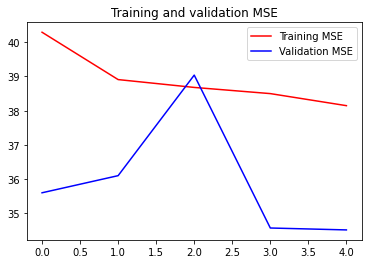

<Figure size 432x288 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt

%matplotlib inline
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
fig1 = plt.gcf()
plt.plot(epochs, acc, 'r', label='Training MSE')
plt.plot(epochs, val_acc, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend(loc=0)
fig1.savefig('accuracy_plot')

plt.figure()
plt.show()

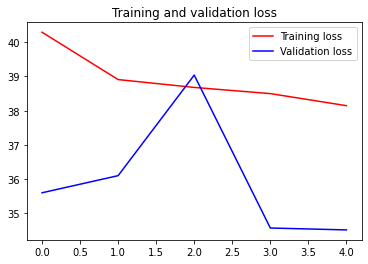

<Figure size 432x288 with 0 Axes>

In [62]:
fig1 = plt.gcf()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.savefig('loss_plot')

plt.figure()
plt.show()

In [63]:
scores = model.predict(test_den,verbose=1)

32/32 [==============================] - 194s 6s/step


In [64]:
scores

array([[9.059406 ],
       [7.6900325],
       [8.989528 ],
       ...,
       [8.723275 ],
       [5.3393517],
       [8.134462 ]], dtype=float32)

In [65]:
result = test_df
result['predicted'] = scores
result['mape'] = abs((result['weighted_score'] - result['predicted']) / result['weighted_score']) * 100
result.to_csv('results.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
result

,poster_path,weighted_score,predicted,mape
839,drive/MyDrive/images/1kzUhxh9waTvbV4yW1fU1TaaC...,6.354360,9.059406,42.569919
8136,drive/MyDrive/images/57sYkbVtYf8CarhdpcLJoFUwD...,7.707231,7.690032,0.223143
8358,drive/MyDrive/images/rRlvKreD88Fj6cUbc2WPxKISx...,6.449695,8.989528,39.379114
5017,drive/MyDrive/images/8x92ekqR0bR9qBIJLpr7xX7yC...,6.536136,9.989450,52.834200
5273,drive/MyDrive/images/s6DJXJU3HzX24Ij3VWg5MfVGH...,11.030830,7.644886,30.695285
...,...,...,...,...
8702,drive/MyDrive/images/5V10mg1rAbwWYNF6IjnEYokIR...,6.701392,9.617486,43.514757
5341,drive/MyDrive/images/uiXr41VLYsuug3CZbFrKLSNah...,7.898298,8.462655,7.145305
4203,drive/MyDrive/images/hCUrI8v523NQDJNKoDxGq2nvb...,7.174515,8.723275,21.586973
670,drive/MyDrive/images/foQnDv051kQ7satMQkbkPsUxz...,6.649451,5.339352,19.702363


In [67]:
MAPE = result[(result['mape'] <= 100) & (result['mape'] >= 0)]['mape'].mean()

In [68]:
MAPE

28.739179288753245

In [69]:
import numpy as np

MAPE_RAW = result[~result.isin([np.nan, np.inf, -np.inf]).any(1)]['mape'].mean()

In [70]:
MAPE_RAW

28.739179288753245

In [71]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true = result['weighted_score'], y_pred = result['predicted'])
RMSE = MSE**(0.5)

In [72]:
print(MSE)
print(MSE**(0.5))

45.186811277832106
6.722113601973126


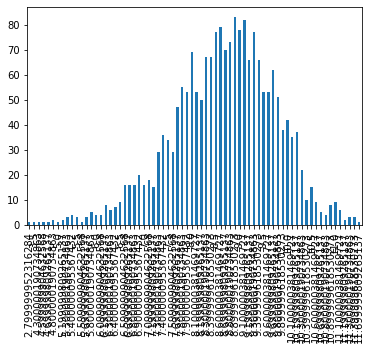

In [73]:
fig1 = plt.gcf()
pd.value_counts(result['predicted'].round(1)).sort_index().plot(kind="bar")
fig1.savefig('img')